<a href="https://colab.research.google.com/github/chang9711/BIPS/blob/main/KCVS/TA_session/TA_session_BIPS_answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TA_session_BIPS

Programming tutorial of paper, "BIPS: Bi-modal Indoor Panorama Synthesis via Residual Depth-aided Adversarial Learning", *ECCV 2022*.

<br>

Paper: https://www.ecva.net/papers/eccv_2022/papers_ECCV/papers/136760331.pdf

Github: https://github.com/chang9711/BIPS

Lab website: http://vi.kaist.ac.kr/

<br>

TA: Changgyoon Oh (Changgyoon@kaist.ac.kr), Daehee Park (bag2824@kaist.ac.kr)

## 0) 드라이브 마운트 & 필요한 라이브러리 임포트

---


In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/KCVS/TA_session')

Mounted at /content/drive


In [ ]:
import math
import random
from tqdm import tqdm

import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torch.nn.functional as F

from config import config     ## 데이터 로드 및 모델 구축에 사용한 hyper parameter들 저장해놓은 configuration
from custom_layers import *

seed=1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

### Overall Structure

![overall_all](https://drive.google.com/uc?id=1Y1IV8yRyTpEnQN9vO6UQY4vbPIb0z9Bs)

#### 실습 내용:

* 데이터 로더 (인풋, 아웃풋) 정의

* Mask 정의

* Generator 정의

* FAED score 계산을 위한 Autoencoder 정의

* 테스트 및 Visualization

![overall_dataloader](https://drive.google.com/uc?id=14Cpi8X6sELWez4o8WFcW16mLWSwWstPp)

## 1) 데이터로더 정의

* Input: 카메라/LiDAR로 취득한 partial RGBD data
* Output: 360도 RGB-D 이미지

<br>


> Input, Output 모두 ERP image


<br>

![model_overview](https://drive.google.com/uc?id=1JXFGbn0WRgyUwfJ-PJHC7Y2qCyY0lmgD)

<br>


---


### ERP image 란?

![ERP_image](https://drive.google.com/uc?id=1KUVSnesJLKns9-AWB6Dhhk4_TNJpM4Na)
\( 출처: [paper](https://www.arxiv-vanity.com/papers/1907.11830/) \)

<br>


**E**qui **R**ectangular **P**rojection Image (등장방형도법)

* 전방향 카메라 정보를 정규화된 격자 형태로 나타낼 수 있는 이미지 projection 형식

* longitude ($\theta$), latitude ($\phi$)의 격자 이미지로 나타냄

* 익숙한 CNN을 바로 사용 할 수 있는 장점이 있음

* nFoV 이미지는 ERP 상의 <u>빨간색 라인</u>으로 표시된 영역과 같이 Projection 됨

* LiDAR 데이터도 $\theta$, $\phi$ 정보를 사용하여 Projection할 수 있음



---


<br>


### 360도 Depth Output의 경우, room layout (lay)과 residual (res)로 나누어 생성

Depth image = Layout Depth image ($D_{lay}$) + Residual Depth image ($D_{res}$)


<br>


![Depths](https://drive.google.com/uc?id=157exxniAi5OxQI_EpzH54UKSP8FjRvGV)


<br>


Layout Depth image 는 실내 벽의 구조적 정보를 포함하고 있음

Residual Depth image 는 실내 items의 구조적 정보를 포함하고 있음



In [ ]:
class dataloader:
    def __init__(self, config):

        print('[*] initializing data loader...')

        self.config = config
        self.root_test = config.test_data_root
        self.imsize = config.imsize
        self.scale_d = config.scale_d
        self.d_res_hmax = config.d_res_hmax
        self.depth_thres = config.depth_thres
        self.residual_thres = config.residual_thres

        if torch.cuda.is_available():
            self.use_cuda = True
            torch.set_default_tensor_type('torch.cuda.FloatTensor')
        else:
            self.use_cuda = False
            torch.set_default_tensor_type('torch.FloatTensor')

        self.RGB_folder_test = self.root_test + "/RGB"
        RGB_list_test = os.listdir(self.RGB_folder_test)
        RGB_list_test.sort()
        self.len_data_test = len(RGB_list_test)
        self.RGB_list_test = RGB_list_test
        
        self.D_folder_test = self.root_test + "/D"
        D_list_test = os.listdir(self.D_folder_test)
        D_list_test.sort()
        self.D_list_test = D_list_test

        self.D_ini_folder_test = self.root_test + "/D_ini"
        D_ini_list_test = os.listdir(self.D_ini_folder_test)
        D_ini_list_test.sort()
        self.D_ini_list_test = D_ini_list_test
      
        print('[*] data loader initialized.')

    def read_input_test(self, idx):
        rgb_path = self.RGB_folder_test
        rgb_list = self.RGB_list_test
        d_path = self.D_folder_test
        d_list = self.D_list_test
        d_ini_path = self.D_ini_folder_test
        d_ini_list = self.D_ini_list_test

        rgb = torch.zeros(1, 3, self.imsize, 2*self.imsize)
        d = torch.zeros(1, 1, self.imsize, 2*self.imsize)
        d_ini = torch.zeros(1, 1, self.imsize, 2*self.imsize)
        d_res = torch.zeros(1, 1, self.imsize, 2*self.imsize)

        # color image loading.
        rgb_ = Image.open(rgb_path + "/" + rgb_list[idx], 'r')
        rgb_ = np.asarray(rgb_.resize((2*self.imsize, self.imsize), Image.BILINEAR))

        rgb_ = (rgb_[:,:,:3])

        # transform pixel space into [-1, 1]
        rgb_ = (rgb_/255) * 2 - 1

        # transform into pytorch tensor
        rgb_ = torch.tensor(rgb_).transpose(2,1).transpose(1,0)

        # unsqueeze
        rgb_ =  rgb_.float()
        rgb[0] = rgb_

        # depth image loading.
        d_ = Image.open(d_path + "/" + d_list[idx], 'r')
        d_ = np.asarray(d_.resize((2*self.imsize, self.imsize), Image.NEAREST))
        
        d_ini_ = Image.open(d_ini_path + "/" + d_ini_list[idx], 'r')
        d_ini_ = np.asarray(d_ini_.resize((2*self.imsize, self.imsize), Image.NEAREST))

        d_res_ = d_ini_ - d_
        d_res_ = np.where(((d_res_<self.residual_thres)&(d_res_>-self.residual_thres)),0,d_res_)
        d_res_ = np.where(d_res_<-self.depth_thres,-self.depth_thres,d_res_)

        # transform depth space(d_,d_ini_,d_res_) into [0, 10] (depth data is in uint16)
        d_ = d_  * self.scale_d
        d_ini_ = d_ini_ * self.scale_d
        d_res_ = d_res_ * self.scale_d /self.d_res_hmax + 5        
       
        #transform into pytorch tensor
        d_ = torch.tensor(d_).unsqueeze(0)
        d_ini_ = torch.tensor(d_ini_).unsqueeze(0)
        d_res_ = torch.tensor(d_res_).unsqueeze(0)

        # float
        d_ = d_.float()
        d_ini_ = d_ini_.float()
        d_res_ = d_res_.float()

        d[0] = d_
        d_ini[0] = d_ini_
        d_res[0] = d_res_

        return rgb, d, d_ini, d_res, rgb_path + "/" + rgb_list[idx]

    def get_batch_test(self, idx):
        rgb_gt, d_gt, d_ini_gt, d_res_gt, rgb_path = self.read_input_test(idx)
        
        if self.use_cuda:
            rgb_gt = rgb_gt.cuda()
            d_gt = d_gt.cuda()
            d_ini_gt = d_ini_gt.cuda()
            d_res_gt = d_res_gt.cuda()
        return rgb_gt, d_gt, d_ini_gt, d_res_gt, rgb_path

    def __len__(self):
        return self.len_data_test

![overall_mask](https://drive.google.com/uc?id=1nwg0hR1Zv9hQbS4NSWx1RMbo6-mVANbp)

## 2) 인풋 데이터 생성을 위한 이미지 마스크 생성

3가지 인풋 시나리오 가정 &rarr; 3가지 상황을 확률적으로 샘플링

>  1. RGB 이미지만 주어지는 경우
>  2. Depth 정보만 주어지는 경우
>  3. RGB와 Depth가 모두 주어지는 경우


RGB 이미지는 **NFoV 카메라**를 통해 얻을 수 있음

Depth 정보는 **NFoV depth 카메라** (Azure Kinect, etc.) 또는 **LiDAR**를 통해 얻을 수 있음 &rarr; 2가지 상황을 확률적으로 샘플링

<br>

* NFoV 마스크 예시 

<br>

![NFoV_mask](https://drive.google.com/uc?id=1LNEOoUt41Oq7IAGlTqj6E8hW3CNYuwEZ) 

<br>

* LiDAR 마스크 예시

<br>

![LiDAR_mask](https://drive.google.com/uc?id=16noJ0FNuFniS7eYjUS8dCJow2GoxTgz0)


In [ ]:
def generate_input_mask_batch(config, img_grid):
    mask = generate_input_mask(img_grid).unsqueeze(0)
    for batch in range(1,config.batchsize):
        mask = torch.cat([mask, generate_input_mask(img_grid).unsqueeze(0)], dim=0)
    return mask

def generate_input_mask(img_grid):
    
    # this function generates the final input mask.
    input_mode = random.random() # switch btw RGB, D, RGBD input modes. sample from 0~1 uniform distribution.

    if input_mode < 1/3: # RGB only case
        input_mask = generate_rgb_only_mask(img_grid)
        return input_mask
        
    elif 1/3 <= input_mode < 2/3: # D only case
        d_mode = random.random() # switch btw nfov and lidar modes. sample from 0~1 uniform distribution.
        if d_mode < 1/2: # nfov D case
            input_mask = generate_d_only_nfov_mask(img_grid)
        else: # lidar D case
            input_mask = generate_d_only_lidar_mask(img_grid)
        return input_mask

    else: # RGBD case
        d_mode = random.random() # switch btw nfov and lidar modes. sample from 0~1 uniform distribution.
        if d_mode < 1/2:
            input_mask = generate_rgbd_nfov_mask(img_grid)
        else:
            input_mask = generate_rgbd_lidar_mask(img_grid)
        return input_mask

def generate_rgbd_lidar_mask(img_grid):
    lidar_mask = generate_LIDAR_mask(img_grid)
    nfov_mask = generate_nfov_mask(img_grid)

    nfov_mask = nfov_mask.unsqueeze(0)
    lidar_mask = lidar_mask.unsqueeze(0)
    mask = torch.cat( [nfov_mask, nfov_mask, nfov_mask, lidar_mask], dim=0 )
    return mask

def generate_d_only_lidar_mask(img_grid):
    lidar_mask = generate_LIDAR_mask(img_grid)

    lidar_mask = lidar_mask.unsqueeze(0)
    nfov_mask = torch.zeros_like(lidar_mask)
    mask = torch.cat( [nfov_mask, nfov_mask, nfov_mask, lidar_mask], dim=0 )
    return mask

def generate_rgbd_nfov_mask(img_grid):
    nfov_mask = generate_nfov_mask(img_grid)

    nfov_mask = nfov_mask.unsqueeze(0)
    mask = torch.cat( [nfov_mask, nfov_mask, nfov_mask, nfov_mask], dim=0 )
    return mask

def generate_rgb_only_mask(img_grid):
    nfov_mask = generate_nfov_mask(img_grid)

    nfov_mask = nfov_mask.unsqueeze(0)
    lidar_mask = torch.zeros_like(nfov_mask)
    mask = torch.cat( [nfov_mask, nfov_mask, nfov_mask, lidar_mask], dim=0 )
    return mask

def generate_d_only_nfov_mask(img_grid):
    nfov_mask = generate_nfov_mask(img_grid)

    nfov_mask = nfov_mask.unsqueeze(0)
    rgb_mask = torch.zeros_like(nfov_mask)
    mask = torch.cat( [rgb_mask, rgb_mask, rgb_mask, nfov_mask], dim=0 )
    return mask


### Mask 생성 방법

인풋 데이터는 mask simulation을 통해 얻을 수 있음

> Partial 인풋 정보를 ERP 이미지 상에 매핑하는 것 ≃ 전체 ERP 이미지로부터 인풋 영역을 마스킹 하는 것


![NFoV_mask](https://drive.google.com/uc?id=1PpnNkFMniIkOXt-CwD8_bW2m8DmJAPQ_)

\( 출처: [paper](https://arxiv.org/pdf/1907.09233.pdf) \)

In [ ]:
def get_global_img_grid(config):
    # mesh grid generation.
    x = np.linspace(-math.pi , math.pi , 2*config.imsize)
    y = np.linspace(math.pi/2 , -math.pi/2 , config.imsize)
    theta, phi = np.meshgrid(x, y)
    theta = torch.tensor(theta).cuda()
    phi = torch.tensor(phi).cuda()

    # get the position along the principal axis(z-axis) on the unit sphere, in erp image coordinate.
    z_erp = torch.cos(phi) * torch.cos(theta)
    x_erp = torch.cos(phi) * torch.sin(theta)
    y_erp = torch.sin(phi)

    return [theta, phi, x_erp, y_erp, z_erp]

def generate_nfov_mask(img_grid):
    # this function generates mask of nfov images of multiple cams on the ERP image grid using pitch angle.
    # in current implementation, the yaw angles between the cameras are set to have the same angular intervals.
    # this function takes approximately 1ms using torch cuda tensor operations.
    
    hor_fov = float(random.randint(60,90))
    ver_fov = float(random.randint(60,90))
    pitch = float(random.randint(-90, 90))
    n_cam = random.randint(1,int(max(min((90/(abs(pitch)+1e-9)),4),1))) # n_cam is adaptive to pitch angle (if pitch=90, n_cam is always 1.)
    flip = random.random()

    theta = img_grid[0]
    phi = img_grid[1]
    x_erp = img_grid[2]
    y_erp = img_grid[3]
    z_erp = img_grid[4]

    pitch = pitch * math.pi / 180
    yaw = math.pi * 2 / n_cam

    # max x and y value in the NFoV image plane.  
    max_y = math.tan( (ver_fov+2*pitch)*math.pi/(2*180))
    max_x = math.tan( hor_fov*math.pi/(2*180))
    min_y = math.tan( (-ver_fov+2*pitch)*math.pi/(2*180))
    min_x = math.tan( -hor_fov*math.pi/(2*180))

    # tilt the coordinate along x-axis using the pitch angle to get the nfov image coordinate.
    x_nfov = x_erp
    z_nfov = z_erp*math.cos(pitch) + y_erp*math.sin(pitch)
    y_nfov = -z_erp*math.sin(pitch) + y_erp*math.cos(pitch)

    mask = torch.zeros_like(phi) # initializing mask var.

    for cam in range(n_cam):
        # tilt the coordinate along y-axis using the pitch angle to get the nfov image coordinate.
        tilt_angle = yaw * cam

        y_nfov_ = y_nfov
        z_nfov_ = z_nfov*math.cos(tilt_angle) + x_nfov*math.sin(tilt_angle)
        x_nfov_ = -z_nfov*math.sin(tilt_angle) + x_nfov*math.cos(tilt_angle)

        # shoot the ray until z_nfov=1. We set the NFoV image plane is z_nfov=1 plane. (in other words, z axis is the principal axis)
        y = y_nfov_ / (z_nfov_ + 1e-9)
        x = x_nfov_ / (z_nfov_ + 1e-9)
        z = z_nfov_
        
        # masking the values that have appropriate FoV with positive z_nfov position.
        mask += (y > min_y) * (y < max_y) * (x > min_x) * (x < max_x) * (z >= 0)

    if flip < 1/2:
        mask = torch.flip(mask, [1])
    mask = mask > 0
    
    return torch.tensor(mask).float()

def generate_LIDAR_mask(img_grid): 
    theta = img_grid[0]
    phi = img_grid[1]
    x_erp = img_grid[2]
    y_erp = img_grid[3]
    z_erp = img_grid[4]

    channel = 2 ** random.randint(1,4)
    vert_fov_down = float(random.randint(1, 3) * channel )
    vert_fov_up = float(random.randint(1, 3) * channel )
    pitch = float(random.randint(-90, 90))
    yaw = random.randint(0,360)

    vert_fov_down = (-vert_fov_down) * math.pi / 180  # convert: degree -> radian [pi/2, -pi/2]
    vert_fov_up = (vert_fov_up) * math.pi / 180 # convert: degree -> radian [pi/2, -pi/2]
    pitch = pitch * math.pi / 180 # in radian
    yaw = int(yaw * img_grid[0].shape[1] / 360) # in pixel.

    # tilt the coordinate along x-axis using the pitch angle to get the lidar.
    x_lidar = x_erp
    z_lidar = z_erp*math.cos(pitch) + y_erp*math.sin(pitch)
    y_lidar = -z_erp*math.sin(pitch) + y_erp*math.cos(pitch)

    # sample lidar points using y value.
    vert_interval = (vert_fov_up - vert_fov_down) / channel

    mask = torch.zeros_like(phi)
    margin = math.pi / (phi.shape[0]) # margin is a hyper-parameter.
    for c in range(channel):
        angle = vert_fov_up - c * vert_interval
        mask += ((angle - margin < y_lidar) * (y_lidar < angle + margin) )

    mask = torch.roll(mask, yaw, dims=1)
    mask = mask > 0

    return torch.tensor(mask).float()

### 랜덤 마스크 생성 예시

<ipython-input-19-f577867501b1>:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(mask).float()
<ipython-input-19-f577867501b1>:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(mask).float()


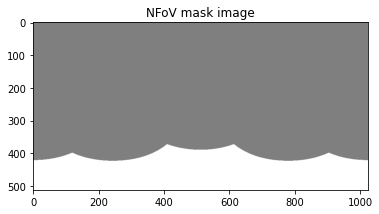

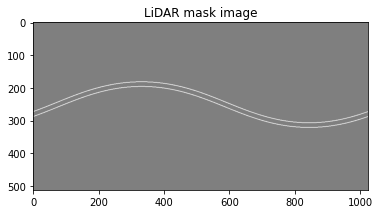

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_grid = get_global_img_grid(config)

rgb_out = generate_nfov_mask(img_grid)
rgb_out = rgb_out.unsqueeze(0).unsqueeze(0)
rgb_out = torch.cat([rgb_out, rgb_out, rgb_out], dim=1)

depth_out = generate_LIDAR_mask(img_grid)
depth_out = depth_out.unsqueeze(0).unsqueeze(0)
depth_out = torch.cat([depth_out,depth_out,depth_out], dim=1)

outr = np.array(rgb_out.cpu().transpose(1,2).transpose(3,2)) # Batch, Height, Width, Channel
img_r = (255*(outr+1)/2).astype(np.uint8)[0]
imr = Image.fromarray(img_r)

outd = np.array(depth_out.cpu().transpose(1,2).transpose(3,2)) # Batch, Height, Width, Channel
img_d = (255*(outd+1)/2).astype(np.uint8)[0]
imd = Image.fromarray(img_d)

plt.figure()
plt.title('NFoV mask image')
plt.imshow(imr)
plt.show()

plt.figure()
plt.title('LiDAR mask image')
plt.imshow(imd)
plt.show()

plt.close()
del img_grid, rgb_out, depth_out, outr, img_r, imr, outd, img_d, imd

![model_overview](https://drive.google.com/uc?id=14yJ3BuwuxUNUXT0FVq7eV0bKXWw9pFyq)


## 3) 네트워크 정의 - Main model




### Generator 정의

본 tutorial 에서는 training을 수행하지 않기 때문에 Discriminator는 사용하지 않음


#### Generator 구조
![generator_str](https://drive.google.com/uc?id=1GcF05QdwyR6F1XmdehZjp1MdPi4sLrK_)

크게 보면, Input Branch - Downsample Block - Mid Block - Upsample Block - Output Branch 로 이루어짐

* Input Branch: Partial RGB/D 인풋을 두개의 branch가 encode
* Downsample Block: Feature size를 줄이면서 global 정보를 encode
* Mid Block: Feature size를 동일하게 유지하면서 encode
* Upsample Block: Feature size를 증가시키면서 이미지 decode
* Output Branch: Full RGB, Depth-layout (ini), Depth-residual (res)를 세개의 branch에서 decode

<br>

* Downsample, Mid, Upsample branch에서 1) RGB-D feature간의 정보 교환, 2) Residual connection 존재
  * 1) 다른 mode에서 촬영된 정보로부터 이미지를 추론할 수 있도록 함
  * 2) Detail한 정보를 복원할 수 있도록 함



In [ ]:
class Generator(nn.Module):
    def __init__(self, config):
        super(Generator, self).__init__()
        self.config = config
        self.flag_bn = config.flag_bn
        self.flag_in = config.flag_in
        self.flag_pixelwise = config.flag_pixelwise
        self.flag_wn = config.flag_wn
        self.flag_leaky = config.flag_leaky
        self.flag_tanh = config.flag_tanh
        self.flag_sigmoid_depth = config.flag_sigmoid_depth
        self.flag_norm_latent = config.flag_norm_latent
        self.nc = len(config.input_mode)
        self.outnc = config.outnc
        self.ngf = config.ngf
        self.max_ngf = config.max_ngf
        self.min_ngf = self.ngf
        self.circular = config.flag_circular_pad

        # input branches.
        self.input_rgb = self.input_branch(3)
        self.input_d = self.input_branch(1)

        # fused data processing layer: U-Net based network.
        self.down1 = self.downsample_block(64)
        self.down1_d = self.downsample_block(64)

        self.down2 = self.downsample_same_block(128)
        self.down2_d = self.downsample_same_block(128)

        self.down3 = self.downsample_same_block(256)
        self.down3_d = self.downsample_same_block(256)

        self.down4 = self.downsample_same_block(256)
        self.down4_d = self.downsample_same_block(256)

        self.mid = self.mid_block(512)
        self.mid_d = self.mid_block(512)

        self.up4 = self.upsample_block(512)
        self.up4_d = self.upsample_block(512)

        self.up3 = self.upsample_block(256)
        self.up3_d = self.upsample_block(256)


        self.up2 = self.upsample_block(256)
        self.up2_d = self.upsample_block(256)

        self.up1 = self.upsample_block(128)
        self.up1_d = self.upsample_block(128)


        # output branches.
        self.output_rgb = self.output_block(3)
        self.output_d_res= self.output_block(1)
        self.output_d_ini = self.output_block(1)

    def input_branch(self, nc):
        layers = []
        ndim = self.ngf
##여기
        layers = conv(layers, nc, ndim, 7, 1, 3, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)

        # downsample once.
        ndim = min(self.max_ngf, self.ngf * 2)
        layers = conv(layers, ndim//2, ndim, 4, 2, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        
        return  nn.Sequential(*layers)



    def downsample_block(self,ngf):
        
        ndim = min(self.max_ngf, ngf * 2)

        layers = []

        layers = conv(layers, ngf, ndim, 4, 2, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)

        
        return  nn.Sequential(*layers)
    
    def downsample_same_block(self, ndim):
        
        layers = []
        
        layers = conv(layers, ndim, ndim, 4, 2, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)

        self.ngf = self.ngf * 2
        
        return  nn.Sequential(*layers)
        

    def mid_block(self,ndim):
        
        layers = []
        
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim//2, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
       
        return  nn.Sequential(*layers)

    def upsample_block(self,ngf):
        
        ndim = ngf//2

        layers = []
        layers.append(nn.Upsample(scale_factor=2, mode='bilinear'))       # scale up by factor of 2.0
        
        layers = conv(layers, ngf, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)

        
        return  nn.Sequential(*layers)

    def upsample_same_block(self,ndim):
        
        layers = []
        layers.append(nn.Upsample(scale_factor=2, mode='bilinear'))       # scale up by factor of 2.0
        
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)

        
        return  nn.Sequential(*layers)

    def output_block(self, outnc):

        ndim = 32

        layers = []
        # upsample once.
        layers.append(nn.Upsample(scale_factor=2, mode='bilinear'))       # scale up by factor of 2.0
        layers = conv(layers, 64, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)
        layers = conv(layers, ndim, ndim, 3, 1, 1, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, circular=self.circular)

        # map to the target domain.
        layers = conv(layers, ndim, outnc, 1, 1, 0, self.flag_leaky, self.flag_bn, self.flag_in, self.flag_wn, self.flag_pixelwise, only=True, circular=self.circular)
        
        return nn.Sequential(*layers)


    def forward(self, x):
        #x_ = self.first_layer(x)
        rgb = x[:,:3]
        rgb = self.input_rgb(rgb)
        
        d = x[:,3:]
        d = self.input_d(d)

        x1 = self.down1(rgb)
        x1_d = self.down1_d(d)

        x2 = self.down2(x1)
        x2_d = self.down2_d(x1_d)
        
        x2_cat = torch.cat( [x2, x2_d], dim=1 )

        x3 = self.down3(x2_cat)
        x3_d = self.down3_d(x2_cat)
        
        x4 = self.down4(x3)
        x4_d = self.down4_d(x3_d)
            
        x_ = torch.cat( [x4, x4_d], dim=1 )

        xm_ = self.mid(x_)
        xm_d = self.mid_d(x_)

        xm_cat = torch.cat( [xm_, xm_d], dim=1 )

        x4_ = self.up4(xm_cat + x_)
        x4_d_ = self.up4_d(xm_cat + x_)
        
        x3_ = self.up3(x4_ + x3)
        x3_d_ = self.up3_d(x4_d_ + x3_d)

        x3_cat = torch.cat( [x3_, x3_d_], dim=1 )

        x2_ = self.up2(x3_cat + x2_cat)
        x2_d_ = self.up2_d(x3_cat + x2_cat)

        x1_ = self.up1(x2_ + x1)
        x1_d_ = self.up1_d(x2_d_ + x1_d)


        d_res = self.output_d_res(x1_d_ + d)
        d_ini = self.output_d_ini(x1_d_ + d)
        rgb = self.output_rgb(x1_ + rgb)

        
        rgb = torch.tanh(rgb)
        
        d_res = torch.sigmoid(d_res) * 10
        d_ini= torch.sigmoid(d_ini) * 10
        
        
        out = torch.cat([rgb,d_ini,d_res], dim=1)
     

        return out


![overall_faed](https://drive.google.com/uc?id=1BoSnrZ8eRRQq-gQsA9sXZxuToUZj7F7d)

## 4) 네트워크 정의 - FAED score 계산을 위한 Autoencoder 정의




#### Autoencoder 구조

![autoencoder](https://drive.google.com/uc?id=1piyF6REAPTuixWFJFvMJnhzTM_D2Ogrp)

Downsample 하는 Encoder - Upsampling 하는 Decoder로 구성됨

Encoder의 결과물로 얻어진 feature를 FAED score 계산에 사용

Depth 이미지를 layout, residual로 나누지 않음.

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.downconv1_rgb = Conv2d(in_channels = 3, out_channels = 32, kernel_size = 9, stride = 1, padding = 4)
        self.downconv1_d = Conv2d(in_channels = 1, out_channels = 32, kernel_size = 9, stride = 1, padding = 4)
        
        self.downconv2_rgb = ConvBlock(in_channels = 32, out_channels = 64, kernel_size = 4, stride = 2, padding = 1) 
        self.downconv2_d = ConvBlock(in_channels = 32, out_channels = 64, kernel_size = 4, stride = 2, padding = 1) 

        self.downconv3_rgb = ConvBlock(in_channels = 64, out_channels = 128, kernel_size = 4, stride = 2, padding = 1)
        self.downconv3_d = ConvBlock(in_channels = 64, out_channels = 128, kernel_size = 4, stride = 2, padding = 1)

        self.downconv4_rgb = ConvBlock(in_channels = 128, out_channels = 128, kernel_size = 4, stride = 2, padding = 1)
        self.downconv4_d = ConvBlock(in_channels = 128, out_channels = 128, kernel_size = 4, stride = 2, padding = 1)

        self.downconv5_rgb = ConvBlock(in_channels = 128, out_channels = 128, kernel_size = 4, stride = 2, padding = 1)
        self.downconv5_d = ConvBlock(in_channels = 128, out_channels = 128, kernel_size = 4, stride = 2, padding = 1)

        self.downconv6_rgb = ConvBlock(in_channels = 128, out_channels = 128, kernel_size = 4, stride = 2, padding = 1)
        self.downconv6_d = ConvBlock(in_channels = 128, out_channels = 128, kernel_size = 4, stride = 2, padding = 1)

        self.downres1_rgb = ResBlock(in_channels = 32, out_channels = 32, kernel_size = 9, padding = 4)
        self.downres1_d = ResBlock(in_channels = 32, out_channels = 32, kernel_size = 9, padding = 4)

        self.downres2_rgb = ResBlock(in_channels = 64, out_channels = 64, kernel_size = 7, padding = 3)
        self.downres2_d = ResBlock(in_channels = 64, out_channels = 64, kernel_size = 7, padding = 3)

        self.downres3_rgb = ResBlock(in_channels = 128, out_channels = 128, kernel_size = 5, padding = 2)
        self.downres3_d = ResBlock(in_channels = 128, out_channels = 128, kernel_size = 5, padding = 2)

        self.downres4_rgb = ResBlock(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1)
        self.downres4_d = ResBlock(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1)

        self.downres5_rgb = ResBlock(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1)
        self.downres5_d = ResBlock(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1)

        self.fuse = Conv2d(in_channels = 256, out_channels = 256, kernel_size = 3, stride = 1, padding = 1) 

    def forward(self, x):
        rgb = x[:,:3]                   
        rgb = self.downconv1_rgb(rgb)
        rgb = self.downres1_rgb(rgb)
        rgb = self.downconv2_rgb(rgb)
        rgb = self.downres2_rgb(rgb)
        rgb = self.downconv3_rgb(rgb)
        rgb = self.downres3_rgb(rgb)
        rgb = self.downconv4_rgb(rgb)
        rgb = self.downres4_rgb(rgb)
        rgb = self.downconv5_rgb(rgb)
        rgb = self.downres5_rgb(rgb)
        rgb = self.downconv6_rgb(rgb)

        d = x[:,3:]
        d = self.downconv1_d(d)
        d = self.downres1_d(d)
        d = self.downconv2_d(d)
        d = self.downres2_d(d)
        d = self.downconv3_d(d)
        d = self.downres3_d(d)
        d = self.downconv4_d(d)
        d = self.downres4_d(d)
        d = self.downconv5_d(d)
        d = self.downres5_d(d)
        d = self.downconv6_d(d)

        x1 = torch.cat([rgb,d], dim=1)

        x = self.fuse(x1)

        return x ,x1

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.upsampling = nn.functional.interpolate

        self.upconv2_rgb = ConvBlock(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1) 
        self.upconv3_rgb = ConvBlock(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1) 
        self.upconv4_rgb = ConvBlock(in_channels = 128, out_channels = 64, kernel_size = 3, stride = 1, padding = 1) 
        self.upconv5_rgb = ConvBlock(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1) 

        self.upconv2_d = ConvBlock(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1) 
        self.upconv3_d = ConvBlock(in_channels = 128, out_channels = 128, kernel_size = 3, stride = 1, padding = 1) 
        self.upconv4_d = ConvBlock(in_channels = 128, out_channels = 64, kernel_size = 3, stride = 1, padding = 1) 
        self.upconv5_d = ConvBlock(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1) 

        self.upres2_rgb = ResBlock(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1)
        self.upres3_rgb = ResBlock(in_channels = 128, out_channels = 128, kernel_size = 5, padding = 2) 
        self.upres4_rgb = ResBlock(in_channels = 64, out_channels = 64, kernel_size = 7, padding = 3) 
        self.upres5_rgb = ResBlock(in_channels = 32, out_channels = 32, kernel_size = 9, padding = 4) 
        
        self.upres2_d = ResBlock(in_channels = 128, out_channels = 128, kernel_size = 3, padding = 1)
        self.upres3_d = ResBlock(in_channels = 128, out_channels = 128, kernel_size = 5, padding = 2) 
        self.upres4_d = ResBlock(in_channels = 64, out_channels = 64, kernel_size = 7, padding = 3) 
        self.upres5_d = ResBlock(in_channels = 32, out_channels = 32, kernel_size = 9, padding = 4) 

        self.outconv_rgb = Conv2d(in_channels = 32, out_channels = 3 , kernel_size = 9, stride = 1, padding = 4) 
        self.outconv_d = Conv2d(in_channels = 32, out_channels = 1 , kernel_size = 9, stride = 1, padding = 4) 

    def forward(self, x):

        x = self.upsampling(x, scale_factor = 2 ,mode = 'bilinear', align_corners = False)    
        rgb = x[:,:128]    
        d = x[:,128:]

        rgb = self.upconv2_rgb(rgb)
        rgb = self.upres2_rgb(rgb)
        rgb = self.upsampling(rgb, scale_factor = 2 ,mode = 'bilinear', align_corners = False)
        rgb = self.upconv3_rgb(rgb)
        rgb = self.upres3_rgb(rgb)
        rgb = self.upsampling(rgb, scale_factor = 2 ,mode = 'bilinear', align_corners = False)
        rgb = self.upconv4_rgb(rgb)
        rgb = self.upres4_rgb(rgb)
        rgb = self.upsampling(rgb, scale_factor = 2 ,mode = 'bilinear', align_corners = False)
        rgb = self.upconv5_rgb(rgb)
        rgb = self.upres5_rgb(rgb)
        rgb = self.upsampling(rgb, scale_factor = 2 ,mode = 'bilinear', align_corners = False)
        rgb = self.outconv_rgb(rgb)

        d = self.upconv2_d(d)
        d = self.upres2_d(d)
        d = self.upsampling(d, scale_factor = 2 ,mode = 'bilinear', align_corners = False)
        d = self.upconv3_d(d)
        d = self.upres3_d(d)
        d = self.upsampling(d, scale_factor = 2 ,mode = 'bilinear', align_corners = False)
        d = self.upconv4_d(d)
        d = self.upres4_d(d)
        d = self.upsampling(d, scale_factor = 2 ,mode = 'bilinear', align_corners = False)
        d = self.upconv5_d(d)
        d = self.upres5_d(d)
        d = self.upsampling(d, scale_factor = 2 ,mode = 'bilinear', align_corners = False)
        d = self.outconv_d(d)

        x = torch.cat([rgb,d],dim=1)
        return x



class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        x, _ = self.encoder(x)
        x = self.decoder(x)
        return x

## 5) 테스트 함수 정의 - 인풋으로부터 이미지 생성

* get_activation: latent feature를 생성하는 함수

![latent](https://drive.google.com/uc?id=1wM2Mmw_mzZhV1jM0-jzX0_ZlVbdijBf8)



In [ ]:
def get_activation(x, net, config):

    x,_ = net(x)

    mean_feature = torch.mean( x, dim = 3, dtype = float )

    weight = torch.cos( torch.linspace(math.pi/2 , -math.pi/2 , mean_feature.shape[-1]) ).unsqueeze(0).unsqueeze(0).expand_as(mean_feature)
    mean_feature = weight * mean_feature

    mean_vector = mean_feature.view( -1, config.feature_size )
    
    return mean_vector

* Tester: 이미지 생성, ablation을 위한 class

  * test(): 인풋으로부터 RGBD panorama 생성, get_activateion 함수를 이용해 latent feature 계산 및 저장

  * ablation(): 같은 scene에 대해서 다른 영역을 입력했을때 생성된 이미지 비교

![ablation](https://drive.google.com/uc?id=1yEDAi3zrvW2EtfuTI40sTwY9FllG_V-B)


In [ ]:
flag_stat = True
class Tester:
    def __init__(self, config):
        self.config = config
        self.config.batchsize = 1
        self.scale_d = config.scale_d
        self.d_res_hmax = config.d_res_hmax        
        
        self.global_img_grid = get_global_img_grid(config)
        
        # load trained model.
        # Main model (Generator)
        self.G = Generator(config)
        self.G.eval()
        checkpoint_path = config.G_checkpoint_path
        print("[INFO] load Generator checkpoint from: '{}'".format(checkpoint_path))  
        checkpoint = torch.load(checkpoint_path)
        self.G.load_state_dict(checkpoint['state_dict'])

        # Encoder from AutoEncoder
        self.A = Encoder()
        self.A.eval()
        checkpoint_path = config.E_checkpoint_path
        print("[INFO] load Encoder checkpoint from: '{}'".format(checkpoint_path))  
        checkpoint = torch.load(checkpoint_path)
        checkpoint = dict( (key[8:], value) for (key, value) in checkpoint['state_dict'].items() if 'encoder' in key )
        self.A.load_state_dict(checkpoint, strict=False) 

        self.name = self.config.name
        print('name:',self.name)

        if torch.cuda.is_available():
            self.use_cuda = True
            torch.set_default_tensor_type('torch.cuda.FloatTensor')
        else:
            self.use_cuda = False
            torch.set_default_tensor_type('torch.FloatTensor')
        
        if self.use_cuda:
            self.G = torch.nn.DataParallel(self.G).cuda(device=0)
            self.A = torch.nn.DataParallel(self.A).cuda(device=0)
        
        # dataloader.
        self.loader = dataloader(config)

        
    def test(self):
        num_data = len(self.loader)

        data = np.zeros([1, config.feature_size])
        mean = np.zeros([config.feature_size])
        
        for iter in tqdm(range(0,self.loader.len_data_test)):
            with torch.no_grad():                    
                rgb_gt, d_gt, d_ini_gt, d_res_gt, rgb_path = self.loader.get_batch_test(idx = iter)

                # random mask
                # input_mask = generate_input_mask_batch(self.config, self.global_img_grid)

                # preset mask
                rgb_mask = Image.open(rgb_path.replace("RGB/", "RGB_mask/").replace(".png", "_mask1.png"), "r")
                depth_mask = Image.open(rgb_path.replace("RGB/RGB", "D_mask/Depth").replace(".png", "_mask1.png"), "r")
                rgb_mask = torch.tensor(np.array(rgb_mask)).cuda().permute(2, 0, 1).unsqueeze(0) / 255
                depth_mask = torch.tensor(np.array(depth_mask)).cuda().permute(2, 0, 1)[0:1].unsqueeze(0) / 255
                input_mask = torch.cat((rgb_mask, depth_mask), 1)

                input = torch.cat( [rgb_gt, d_gt], dim=1 )

                in_img = input_mask * input


                x_test = self.G(in_img)
                
                outp_rgb = x_test[:,:3,:,:]
                
                outp_d_ini = x_test[:,3:4,:,:]/((2**16-1)*self.scale_d)
                outp_d_res = (x_test[:,-1:,:,:]-5)*self.d_res_hmax/((2**16-1)*self.scale_d)
                
                outp_d = outp_d_ini-outp_d_res
                outp_d = torch.where(outp_d<0,torch.tensor(0,dtype=torch.float),outp_d)
                outp_d = outp_d * ((2**16-1)*self.scale_d)

                x_test = torch.cat( [outp_rgb, outp_d], dim=1 )

                if flag_stat:
                    act = get_activation(x_test, self.A, config)

                    act = act.detach().cpu().data.numpy()
                    data = np.append(data, act, axis=0)
                    mean += act.sum(axis=0)


        if flag_stat:
            mean /= num_data
            data = np.array(data[1:])

            mean = np.mean(data, axis=0)
            cov = np.cov(data, rowvar = False)

            path = 'stats'
            if not os.path.exists(path):
                if os.name == 'nt':
                    os.system('mkdir {}'.format(path.replace('/', '\\')))
                else:
                    os.system('mkdir -p {}'.format(path))

            np.savez(f'{path}/{config.name}', mean=mean, cov=cov)
            print(f"[INFO] statistics of the data: has been saved to: '{path}/'{config.name}'.")

        return input, input_mask, in_img, x_test

    def ablation(self):
        
        with torch.no_grad():                    
            rgb_gt, d_gt, d_ini_gt, d_res_gt = self.loader.get_batch_test(idx = -1)

            input_mask_1 = generate_input_mask_batch(self.config, self.global_img_grid)
            input_mask_2 = generate_input_mask_batch(self.config, self.global_img_grid)

            input = torch.cat( [rgb_gt, d_gt], dim=1 )

            in_img_1 = input_mask_1 * input
            in_img_2 = input_mask_2 * input

            x_test_1 = self.G(in_img_1)
            x_test_2 = self.G(in_img_2)
            
            outp_rgb_1 = x_test_1[:,:3,:,:]
            outp_rgb_2 = x_test_2[:,:3,:,:]
            
            outp_d_ini_1 = x_test_1[:,3:4,:,:]/((2**16-1)*self.scale_d)
            outp_d_res_1 = (x_test_1[:,-1:,:,:]-5)*self.d_res_hmax/((2**16-1)*self.scale_d)
            outp_d_ini_2 = x_test_2[:,3:4,:,:]/((2**16-1)*self.scale_d)
            outp_d_res_2 = (x_test_2[:,-1:,:,:]-5)*self.d_res_hmax/((2**16-1)*self.scale_d)
            
            outp_d_1 = outp_d_ini_1-outp_d_res_1
            outp_d_1 = torch.where(outp_d_1<0,torch.tensor(0,dtype=torch.float),outp_d_1)
            outp_d_1 = outp_d_1 * ((2**16-1)*self.scale_d)
            outp_d_2 = outp_d_ini_2-outp_d_res_2
            outp_d_2 = torch.where(outp_d_2<0,torch.tensor(0,dtype=torch.float),outp_d_2)
            outp_d_2 = outp_d_2 * ((2**16-1)*self.scale_d)

            x_test_1 = torch.cat( [outp_rgb_1, outp_d_1], dim=1 )
            x_test_2 = torch.cat( [outp_rgb_2, outp_d_2], dim=1 )


        return input, input_mask_1, input_mask_2, x_test_1, x_test_2

## 6) 테스트 함수 정의 - 생성된 이미지와 GT 이미지로부터 FAED score 계산

![fid](https://drive.google.com/uc?id=18iEagrI7zLsDaWulQiKr0HBvFcs-nTTr)

(출처: GANs Trained by a Two Time-Scale Update Rule
Converge to a Local Nash Equilibrium, NeurIPS 2017)

In [ ]:
def calculate_Frechet_distance(mu1, sigma1, mu2, sigma2):

    diff = (mu1 - mu2).squeeze()
    feature_size = mu1.shape[-1]

    mat = sigma1.bmm(sigma2).squeeze()
    sqrt_cov = torch.tensor(sqrtm(mat.squeeze().cpu().numpy()))
    tr_sqrt_cov = torch.trace(sqrt_cov.squeeze())

    return (diff.dot(diff) + torch.trace(sigma1.squeeze()) + torch.trace(sigma2.squeeze()) - 2 * tr_sqrt_cov)#.clamp(min=0, max=np.inf)


## 7) 모델 테스트 - 이미지 생성 및 latent 저장

In [ ]:
tester = Tester(config)
input, input_mask, in_masked, output = tester.test()

[INFO] load Generator checkpoint from: '/content/drive/MyDrive/KCVS/TA_session/gen_name_residual_branch_two.pth'
[INFO] load Encoder checkpoint from: '/content/drive/MyDrive/KCVS/TA_session/RGBQuality_resume_Structured3d_mod.pth.tar'
name: test
[*] initializing data loader...
[*] data loader initialized.


100%|██████████| 3/3 [00:13<00:00,  4.58s/it]


[INFO] statistics of the data: has been saved to: 'stats/'test'.


![autoencoder](https://drive.google.com/uc?id=1oaFT7wYHy9l3dZ5_exzb2EsHh4uiZFds)

## 8) Visualize

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def visualize(color, depth, num_points, mask=None):
  height = np.shape(depth)[0]
  width = np.shape(depth)[1]

  total = height * width

  depth_raw = out_d.reshape(total)

  depth_vec = np.zeros((total,3))

  depth_vec_h = np.arange(total)
  depth_vec_h = depth_vec_h % height
  depth_vec_h = np.transpose(depth_vec_h.reshape(width, height))

  depth_vec_w = np.arange(total)
  depth_vec_w = depth_vec_w % width
  depth_vec_w = depth_vec_w.reshape(height, width)

  depth_vec_h_coord = math.pi * (0.5 - depth_vec_h / height)
  depth_vec_w_coord = math.pi * 2 * depth_vec_w / width

  depth_vec_h_coord = depth_vec_h_coord.reshape(total)
  depth_vec_w_coord = depth_vec_w_coord.reshape(total)

  depth_vec[:, 0] = depth_raw * np.cos(depth_vec_h_coord) * np.sin(depth_vec_w_coord)
  depth_vec[:, 1] = depth_raw * np.cos(depth_vec_h_coord) * np.cos(depth_vec_w_coord)
  depth_vec[:, 2] = depth_raw * np.sin(depth_vec_h_coord)

  color = color.reshape(total,3)

  if mask is not None:
    mask_f = mask.reshape(-1)
    color = color[mask_f]
    depth_vec = depth_vec[mask_f]

  valid_d_idx = (depth_vec==np.array([0,0,0])).all(-1)
  valid_d_idx = ~valid_d_idx
  depth_vec, color = depth_vec[valid_d_idx], color[valid_d_idx]

  if num_points < depth_vec.shape[0]:
    indices = np.random.choice(depth_vec.shape[0], num_points, replace=False)
    color = color[indices, :]
    depth_vec = depth_vec[indices, :]

  fig = go.Figure(
    data=[go.Scatter3d(
            x=depth_vec[:,0], y=depth_vec[:,1], z=depth_vec[:,2], 
            mode='markers',
            marker=dict(size=1, color=color))],
    layout=dict(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False))))
  fig.show()

RGB mask ratio: 20.95%, Depth mask ratio: 0.00%


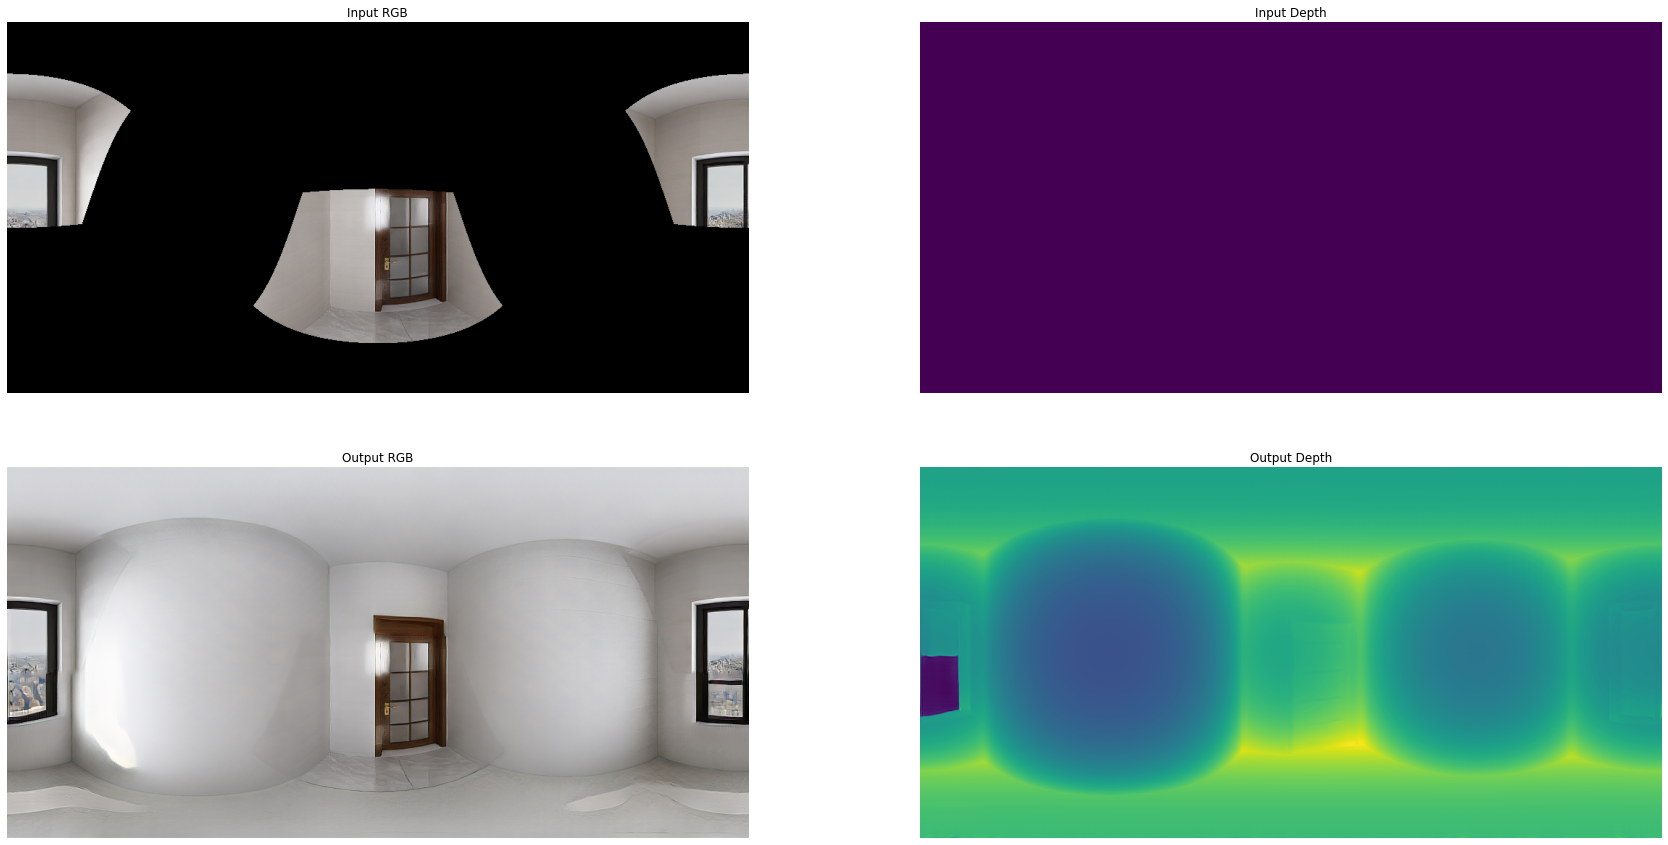

In [ ]:
color_in, depth_in = input[0,:3].permute(1,2,0).detach().cpu(), input[0,-1].detach().cpu()
cmask, dmask = input_mask[0,0].detach().cpu().bool(), input_mask[0,-1].detach().cpu().bool()

out_rgb, out_d = output[0,:3].permute(1,2,0).detach().cpu(), output[0,-1].detach().cpu()

total = cmask.shape[0] * cmask.shape[1]
cmask_ratio = cmask.sum().item()/total*100
dmask_ratio = dmask.sum().item()/total*100
print(f'RGB mask ratio: {cmask_ratio:.2f}%, Depth mask ratio: {dmask_ratio:.2f}%')

color_in = np.array(255*(color_in+1)/2).astype(np.uint8)
inr = color_in.copy()
inr[~cmask] = 0

depth_in = np.array(depth_in.detach().cpu()/config.scale_d).astype(np.uint16)

ind = depth_in.copy()
ind[~dmask] = 0

out_rgb = np.array((out_rgb+1)/2)
out_d = np.array(out_d/config.scale_d).astype(np.uint16)


plt.figure(figsize=(30,15))
ax1 = plt.subplot(2,2,1)
ax1.set_title('Input RGB')
ax1.imshow(inr)
ax1.axis('off')

ax2 = plt.subplot(2,2,2)
ax2.set_title('Input Depth')
ax2.imshow(ind)
ax2.axis('off')

ax3 = plt.subplot(2,2,3)
ax3.set_title('Output RGB')
ax3.imshow(out_rgb)
ax3.axis('off')

ax4 = plt.subplot(2,2,4)
ax4.set_title('Output Depth')
ax4.imshow(out_d)
ax4.axis('off')

plt.show()
plt.close()

In [ ]:
visualize(color_in, depth_in, 20000, mask=cmask)
visualize(color_in, depth_in, 20000, mask=dmask)

visualize(out_rgb, out_d, 20000)


## 9) Ablation - Same scene, difference mask



In [ ]:
input, input_mask_1, input_mask_2, output_1, output_2 = tester.ablation()

In [ ]:
color_in, depth_in = input[0,:3].permute(1,2,0).detach().cpu(), input[0,-1].detach().cpu()
cmask_1, dmask_1 = input_mask_1[0,0].detach().cpu().bool(), input_mask_1[0,-1].detach().cpu().bool()
cmask_2, dmask_2 = input_mask_2[0,0].detach().cpu().bool(), input_mask_2[0,-1].detach().cpu().bool()

out_rgb_1, out_d_1 = output_1[0,:3].permute(1,2,0).detach().cpu(), output_1[0,-1].detach().cpu()
out_rgb_2, out_d_2 = output_2[0,:3].permute(1,2,0).detach().cpu(), output_2[0,-1].detach().cpu()

total = cmask_1.shape[0] * cmask_2.shape[1]

color_in = np.array(255*(color_in+1)/2).astype(np.uint8)
inr1, inr2 = color_in.copy(), color_in.copy()
inr1[~cmask_1] = 0
inr2[~cmask_2] = 0

depth_in = np.array(depth_in.detach().cpu()/config.scale_d).astype(np.uint16)

ind1, ind2 = depth_in.copy(), depth_in.copy()
ind1[~dmask_1] = 0
ind2[~dmask_2] = 0

out_rgb_1 = np.array((out_rgb_1+1)/2)
out_d_1 = np.array(out_d_1/config.scale_d).astype(np.uint16)
out_rgb_2 = np.array((out_rgb_2+1)/2)
out_d_2 = np.array(out_d_2/config.scale_d).astype(np.uint16)


plt.figure(figsize=(20,20))
ax1 = plt.subplot(4,2,1)
ax1.set_title('Input RGB (1)')
ax1.imshow(inr1)
ax1.axis('off')

ax2 = plt.subplot(4,2,2)
ax2.set_title('Input Depth (1)')
ax2.imshow(ind1)
ax2.axis('off')

ax3 = plt.subplot(4,2,3)
ax3.set_title('Output RGB (1)')
ax3.imshow(out_rgb_1)
ax3.axis('off')

ax4 = plt.subplot(4,2,4)
ax4.set_title('Output Depth (1)')
ax4.imshow(out_d_1)
ax4.axis('off')

ax5 = plt.subplot(4,2,5)
ax5.set_title('Input RGB (2)')
ax5.imshow(inr2)
ax5.axis('off')

ax6 = plt.subplot(4,2,6)
ax6.set_title('Input Depth (2)')
ax6.imshow(ind2)
ax6.axis('off')

ax7 = plt.subplot(4,2,7)
ax7.set_title('Output RGB (2)')
ax7.imshow(out_rgb_2)
ax7.axis('off')

ax8 = plt.subplot(4,2,8)
ax8.set_title('Output Depth (2)')
ax8.imshow(out_d_2)
ax8.axis('off')

plt.show()
plt.close()

In [ ]:
visualize(color_in, depth_in, 20000, mask=cmask_1)
visualize(color_in, depth_in, 20000, mask=dmask_1)

visualize(out_rgb_1, out_d_1, 20000)

In [ ]:
visualize(color_in, depth_in, 20000, mask=cmask_2)
visualize(color_in, depth_in, 20000, mask=dmask_2)

visualize(out_rgb_2, out_d_2, 20000)